[Instructions](https://d1b10bmlvqabco.cloudfront.net/attach/jkj3543rivc4b6/it7wlkg448m1f/jmjx01uw123h/nlp_assignment1_final_fixed.pdf)

The goal of this project is to create a model that classifies movie reviews as either 'positive' or 'negative.' I used Torch and other libraries to pre-process, train, validate, and test a model to that end. I used various tokenization scheme and tuned hyperparameters such as the number of n-grams used, the dimensionality of the token embedding space, and the vocabulary size. In the table below, the rest of the hyperparameters are listed along with the validation accuracy: 

|Vocabulary Size| n-grams | tokenization scheme | Learning Rate | Epochs | Batch Size | Embedding Dimensions | Optimizer | Accuracy|
|---------------|---------|---------------------|---------------|--------|------------|----------------------|-----------|---------|
|20000          | 1       | 1                   | .001          | 5 | 10 | 5000 | sgd | 50.53|
|5000 | 3 | 1 | .001 | 4 | 32 | 200 | adam| 82.8|
|8000|4|1|.01|4|50|300|adam|83.9|
|10000|2|1|.01|4|50|2000|adam|84.2|
|15000|1|1|.2|4|50|300|adam|83.1|
|10000|1|1|2|5|40|300|sgd|49.47|
|10000|1|1|1|5|50|300|sgd|56.66|
|10000|1|1|.01|4|50|400|adam|85.1|
|10000|4|1|.0003|4|20|1000|adam|81.6|
|10000|1|2|.01|4|50|400|adam|84.5|
|10000|1|3|.01|4|50|400|adam|85.1|
|10000|1|1|.01|4|20|10|adam|83.7|
|10000|1|1|.01|4|20|30|adam|83.6|

The parameters that seemed to make the most differece in validation accuracy was the vocabulary size, learning rate, and optimizer function. Adam did much better than sgd. The more vocabulary used, the better the model performed. There was a tradeoff in the learning rate: a really low number would gaurentee that the model performed its best, but it took a lot more examples for it to learn. A higher number would risk more variance in the training loss per epoch.

As shown on the table, these were the best set of parameters:

|Vocabulary Size| n-grams | tokenization scheme | Learning Rate | Epochs | Batch Size | Embedding Dimensions | Optimizer | Accuracy|
|---------------|---------|---------------------|---------------|--------|------------|----------------------|-----------|---------|
|10000|1|3|.01|4|50|400|adam|85.1|

It yields a 85.1% accuracy. Here was its learning rate:

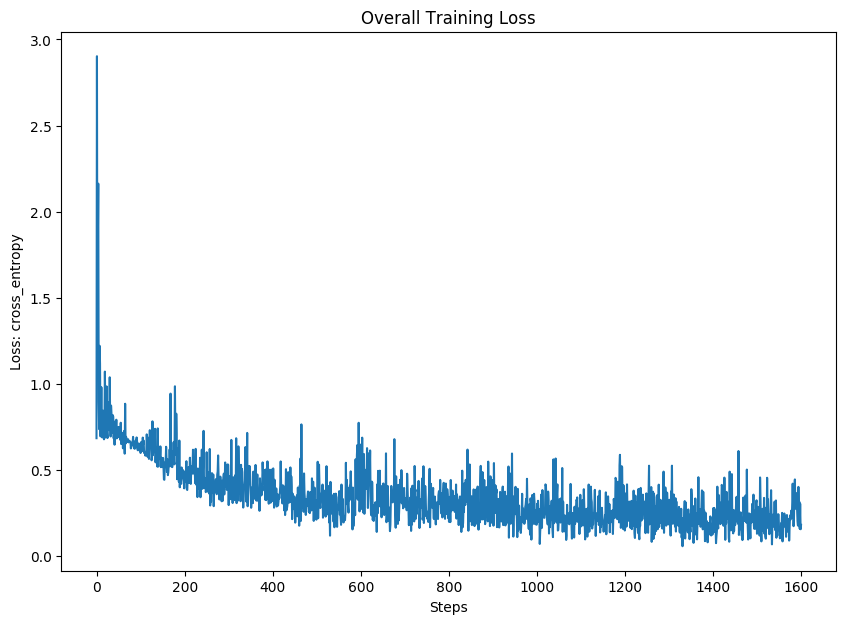

After about 1200 training steps, the model seemed to have learned everything that it could as moving average of the training loss stabilized. After building and training the model, it received a 52% testing accuracy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import spacy
import pickle
from sklearn.model_selection import train_test_split

import string
from collections import Counter

from multiprocessing import Pool, cpu_count
import os
from math import ceil
import time
import re

from functools import reduce

random_state = 42
plt.rcParams["figure.figsize"] = (8,10)

In [2]:
def pool(func, items): 
    p = Pool(cpu_count())
    result = p.map_async(func, items)
    p.close()
    p.join()
    
    return result.get()

def get_pickle(name):
    filename = "{}.pkl".format(name)
    if not os.path.exists(filename):
        return None

    with open(filename, 'rb') as f:
        return pickle.load(f)

def store_pickle(name, obj):
    with open("{}.pkl".format(name), 'wb+') as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)

In [52]:
tokenizer = spacy.load("en_core_web_sm")
stop_words = tokenizer.Defaults.stop_words|set(string.punctuation)|set('')

def pooled_tokenize_scheme1(review):
    stripped_review = re.sub(r'<.*br.*?>', '', review)
    tokens = tokenizer(stripped_review.lower()) 
    return [word.text for word in tokens if word.text not in stop_words]

def pooled_tokenize_scheme2(review):
    stripped_tags = re.sub(r'<.*br.*?>', '', review)
    stripped_entities = stripped_tags.replace("\x91", '').replace("\xa0", '', ).replace("\xad", '', ).replace("\x97", '').replace("\x96", '').replace("\x85", '').replace("\x84", '')        
    
    tokens = tokenizer(stripped_entities.lower()) 
    return [word.text for word in tokens if word.text not in stop_words]

def pooled_tokenize_scheme3(review):
    stripped_tags = re.sub(r'<.*br.*?>', '', review)
    stripped_entities = stripped_tags.replace("\x91", '').replace("\xa0", '', ).replace("\xad", '', ).replace("\x97", '').replace("\x96", '').replace("\x85", '').replace("\x84", '')        
    
    tokens = tokenizer(stripped_entities.lower()) 
    return [word.text for word in tokens if word.text not in stop_words and len(word.text) > 3]
        
def tokenize(reviews, scheme=1, t='train'):
    filename = "{}_tokenized".format(t)
    
    train_tokenized = get_pickle(filename)
    if train_tokenized is None:
        train_tokenized = pool(globals()["pooled_tokenize_scheme{}".format(scheme)], reviews)
        train_tokenized = [review for review in train_tokenized if len(review) > 0]
#     train_tokenized = pool(pooled_tokenize, reviews)
    store_pickle(filename, train_tokenized)
    return train_tokenized

In [71]:
def fetch_data():
    data = fetch_picked()
    if True in [d is None for d in data]:
        print("fetching from file")
        data = fetch_from_file()
    
    return data

def fetch_picked():
    return [get_pickle("train"), get_pickle("train_labels"), get_pickle("test"), get_pickle("test_labels")]

def fetch_from_file():
    def fetch(directory):
        files = os.listdir(directory)
        files_with_directories = ["{}/{}".format(directory, file) for file in files if file.endswith(".txt")]
        return pool(pooled_read_file, files_with_directories) 
    
    paths = {
        "train": {
            "pos": "aclImdb/train/pos",
            "neg": "aclImdb/train/neg"
        },
        "test": {
            "pos": "aclImdb/test/pos",
            "neg": "aclImdb/test/neg"
        }
    }
    
    train_pos = fetch(paths["train"]["pos"])
    train_neg = fetch(paths["train"]["neg"])
    
    train = train_pos + train_neg
    train_labels  = np.concatenate([np.ones(len(train_pos)), np.zeros(len(train_neg))])
    
    test_pos = fetch(paths["test"]["pos"])
    test_neg = fetch(paths["test"]["neg"])
    
    test = test_pos + test_neg
    test_labels  = np.concatenate([np.ones(len(test_pos)), np.zeros(len(test_neg))])
    
    store_pickle("test", test)
    store_pickle("test_labels", test_labels)
    
    store_pickle("train", train)
    store_pickle("train_labels", train_labels)

    return train, train_labels, test, test_labels

def pooled_read_file(filename):
    with open(filename, "r") as f:
        return f.read()

In [72]:
class ReviewsData:
    def __init__(self, use_vocab_percent = 1, ngrams = 1, tokenize_scheme = 1):
        self._fetch()
#         self._tokenize(tokenize_scheme)
#         if ngrams > 1:
#             self.grammify(ngrams)
#         self.build_vocab(use_vocab_percent)
    
    @property
    def vocab_size(self):
        return len(self.vocab)
    
    def get_training(self):
        if hasattr(self, "train_vocab_indices"):
            return self.train_vocab_indices
        if hasattr(self, "train_grammified"):
            return self.train_grammified
        if hasattr(self, "train_tokenized"):
            return self.train_tokenized
        
        return self.train
    
    def prepare_testing(self, n):
        print("Tokenizing test data...")
        self.test_tokenized = tokenize(self.test,1, t="test")
        self.grammify(n, True)
        self.build_vocab(data=self.test_tokenized)
        return self.test_vocab_indices, self.test_labels
    
    def get_training_labels(self):
        return self.train_labels
    
    def grammify(self, n, test=False):
        print("Creating {}-grams...".format(n))
        grams = []
        data = self.test_tokenized if test == True else self.train_tokenized
        for review in data:
            review_grams = []
            review_range = range(len(review) - (n-1))
            for word_index in review_range:
                review_grams.append(
                    [review[i + word_index] for i in range(n)]
                )
            grams.append(review_grams)

        if test == True:
            self.test_grammified = grams
        else:
            self.train_grammified = grams
#         assert(len(self.train_grammified) == len(self.train))
        
    def _fetch(self):
        print("Fetching reviews data...")
        self.train, self.train_labels, self.test, self.test_labels = fetch_data()
    
    def tokenize(self, scheme=1):
        print("Tokenizing...")
        start = time.time()
        self.train_tokenized = tokenize(self.get_training(), scheme)
        end = time.time()
        diff = end - start
        
#         assert(len(self.train_tokenized) == len(self.train))
        
        print("Tokenizing took {} seconds.".format(diff))
        
    def build_vocab(self, vocab_size=10000, data=None):
        if not hasattr(self, "train_grammified") and not hasattr(self, "test_grammified"):
            raise Exception("Must run 'grammify' first.")

        print("Buidling vocab...")
        all_tokens = []
        
        if data is None:
            toknized_data = self.train_tokenized
            grammified_data = self.train_grammified 
        else:
            print("using testing grammified & tokenized data")
            grammified_data = self.test_grammified
            toknized_data = data 
            
        for review_tokens in toknized_data:
            all_tokens += review_tokens
            
        token_counter = Counter(all_tokens)
        vocab, count = zip(*token_counter.most_common(vocab_size))
        token_id_map = dict(zip(vocab, range(len(vocab))))

        token_indices = []
        for review_grams in grammified_data:
            review_indices = [[token_id_map[token] if token in vocab else 0 for token in gram ] for gram in review_grams]
            token_indices.append(review_indices)
        
#         assert(len(token_indices) == len(self.train))
        
        self.vocab = vocab
        self.vocab_id = token_id_map
        if data is not None:
            self.test_vocab_indices = token_indices
        else:
            self.train_vocab_indices = token_indices

In [6]:
class BagOfWords(nn.Module):
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.linear = nn.Linear(emb_dim, 2)

    def forward(self, data):
        embedded = self.embedding(data) # n x length x embdim
        summed = torch.sum(embedded, dim=1)
        midpoint = summed / torch.full(summed.shape, summed.shape[1])
        
        weights = self.linear(midpoint)
        return weights

In [88]:
class Trainer:
    loss_map = {
        "cross_entropy": nn.CrossEntropyLoss(),
    }
    
    def __init__(self, data, labels):
        self.x_train, self.x_valid, self.y_train, self.y_valid = train_test_split(
            data, 
            labels,
            test_size=.2,
            random_state=random_state
        )
        
        self.x_train, self.y_train = self._tensorify(self.x_train, self.y_train)
        self.x_valid, self.y_valid = self._tensorify(self.x_valid, self.y_valid)
        
        self._pad()
        
    def _tensorify(self, xs, ys):
        x_tensors = []
        y_tensors = []
        for i, x, y in zip(range(len(xs)), xs, ys):
            if len(x) == 0:
                continue
            x_tensor = torch.tensor(x).view(1,-1).long()
            y_tensor = torch.tensor([y]).view(1).long()
            
            x_tensors.append(x_tensor)
            y_tensors.append(y_tensor)

        return x_tensors, y_tensors
    
    def _pad(self):
        padded_x = []
        max_length = max([x.shape[1] for x in self.x_train]) - 1
        for row in self.x_train:
            diff = max_length - row.shape[1]
            padded = F.pad(row, (0, diff-1), 'constant', value=-1)
            padded_x.append(padded)
        
        self.x_train = padded_x
     
    def _get_optimizer(self, name, parameters, learning_rate):
        if name == "adam":
            return torch.optim.Adam(parameters, lr=learning_rate)
        if name == "sgd":
            return torch.optim.SGD(parameters, lr=learning_rate)
        
        raise Exception("No such optimizer named {}".format(name))
        
    def _batch(self, batch_size):
        iterations = ceil(len(self.x_train) / batch_size)
        batches = []
        for i in range(iterations):
            from_ = i*batch_size
            to = (i+1) * batch_size
            data = self.x_train[from_:to]
            labels = self.y_train[from_:to]
            
            batched_data = torch.cat(data)
            batched_labels = torch.cat(labels)
            
            batches.append((batched_data, batched_labels))
        
        return batches
            
    def train(self, model, loss_name, optimizer_name, learning_rate, batch_size, epochs):
        loss_fn = self.loss_map[loss_name]
        optimizer = self._get_optimizer(optimizer_name, model.parameters(), learning_rate)
        losses = []
        
        for epoch in range(epochs):
            print("\nStarting epoch {}\n".format(epoch+1))
            batches = self._batch(batch_size)
            epoch_losses = []
            for i, batch in enumerate(batches):
                data, labels = batch
                model.train()
                optimizer.zero_grad()
                
                output = model(data)
                loss = loss_fn(output, labels)
            
                loss.backward()
                
                loss_value = loss.item()
                losses.append(loss_value)
                epoch_losses.append(loss_value)
                
                optimizer.step()
                
                if i > 0 and i % 100 == 0:
                    val_acc = self.validate_acc(model)
                    print(
                        "Epoch: [{}/{}]\t\tStep: [{}/{}]\t\tValidation Acc: {}".format(
                            epoch +1, epochs, i+1, len(batches), val_acc
                        )
                    )
            plt.plot(epoch_losses)
            plt.xlabel("Steps".format(epoch+1))
            plt.ylabel("Loss: {}".format(loss_name))
            plt.title("Epoch {} Loss".format(epoch+1))
            plt.show()
        
        plt.plot(losses)
        plt.xlabel("Steps".format(epoch+1))
        plt.ylabel("Loss: {}".format(loss_name))
        plt.title("Overall Training Loss" )
        plt.show()
                
    def validate_acc(self, model):
        correct = 0
        total = 0
        model.eval()
        for data, label in zip(self.x_valid, self.y_valid):
            outputs = F.softmax(model(data.long()), dim=1)
            predicted = outputs.max(1, keepdim=True)[1]

            total += label.size(0)
            correct += predicted.eq(label.view_as(predicted)).sum().item()
        
        return (100 * correct / total)

    def test(self, model, test_data, test_labels):
        correct = 0
        total = 0
        X, y = self._tensorify(test_data, test_labels)
        model.eval()
        predictions = []
        for data, label in zip(X, y):
            outputs = F.softmax(model(data.long()), dim=1)
            predicted = outputs.max(1, keepdim=True)[1]
            predictions.append((data, label, predicted))

            total += label.size(0)
            correct += predicted.eq(label.view_as(predicted)).sum().item()
        
        return (100 * correct / total), predictions

In [89]:
param_names = ["Percentage of vocabulary", "n-grams", "Tokenization Scheme", "Learning Rate", "Epochs", "Batch Size", "Embedding Dimensions", "Optimizer", "Loss Function"]

def run(data, vocab, grams, scheme, rate, pochs, batch_s, embeds_dim, opt, loss):
    data.tokenize(scheme)
    data.grammify(grams)
    data.build_vocab(vocab)
    
    train = data.get_training()
    train_labels = data.get_training_labels()[:-8]
    
    model = BagOfWords(data.vocab_size, embeds_dim)
    trainer = Trainer(train, train_labels)
    trainer.train(model, loss, opt, rate, batch_s, pochs)
    return model, trainer

def run_params(params):
    for i, p in enumerate(params):
        print("Experiment #{} \033[1mParams\033[0m".format(i+1))    
        params_str = "\n".join(["{}: \033[1m{}\033[0m".format(name, val) for val, name in zip(p[1:], param_names)])
        print(params_str)
        
        print("\n\n")
        run(*p)

In [90]:
data = ReviewsData()

Fetching reviews data...


In [ ]:
params2 = [
    [data, 5000, 3, 1, .001, 4, 32, 200, "adam", "cross_entropy"],
    [data, 8000, 4, 1, .01, 4, 50, 300, "adam", "cross_entropy"],
    [data, 10000, 2, 1, .01, 4, 50, 2000, "adam", "cross_entropy"],
    [data, 15000, 1, 1, .2, 4, 50, 300, "adam", "cross_entropy"],
    [data, 10000, 1, 1, 2, 5, 40, 300, "sgd", "cross_entropy"],
    [data, 10000, 1, 1, 1, 5, 50, 300, "sgd", "cross_entropy"],
    [data, 10000, 1, 1, .01, 4, 50, 300, "adam", "cross_entropy"],
]

run_params(params2)

Experiment #1 Params
Percentage of vocabulary: 10000
n-grams: 4
Tokenization Scheme: 1
Learning Rate: 0.0003
Epochs: 4
Batch Size: 20
Embedding Dimensions: 1000
Optimizer: adam
Loss Function: cross_entropy



Tokenizing...
Tokenizing took 0.9093890190124512 seconds.
Creating 4-grams...
Buidling vocab...

Starting epoch 1

Epoch: [1/4]		Step: [101/997]		Validation Acc: 57.37211634904714
Epoch: [1/4]		Step: [201/997]		Validation Acc: 61.36409227683049
Epoch: [1/4]		Step: [301/997]		Validation Acc: 62.26680040120361
Epoch: [1/4]		Step: [401/997]		Validation Acc: 65.51654964894684
Epoch: [1/4]		Step: [501/997]		Validation Acc: 69.68906720160481
Epoch: [1/4]		Step: [601/997]		Validation Acc: 70.47141424272819
Epoch: [1/4]		Step: [701/997]		Validation Acc: 72.51755265797392
Epoch: [1/4]		Step: [801/997]		Validation Acc: 72.37713139418254
Epoch: [1/4]		Step: [901/997]		Validation Acc: 74.40320962888666


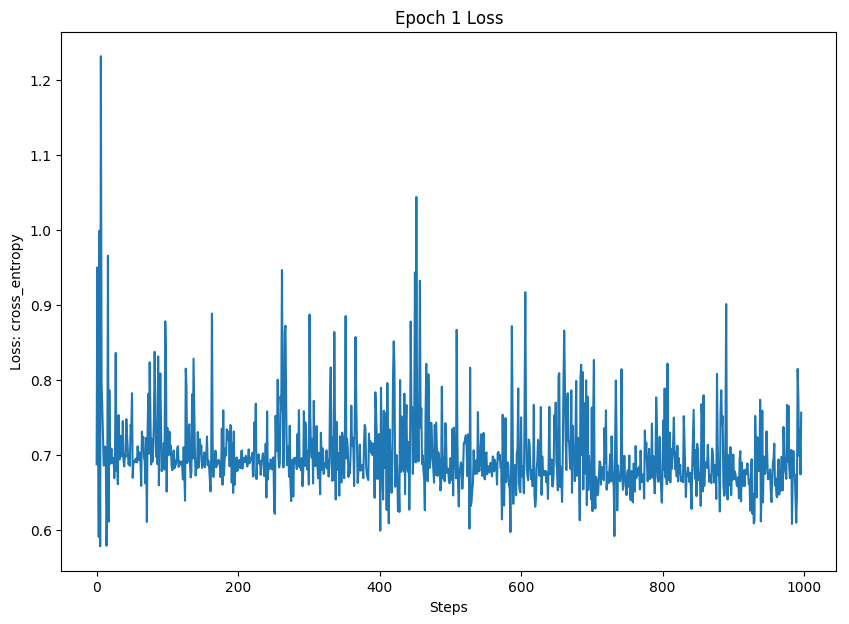


Starting epoch 2

Epoch: [2/4]		Step: [101/997]		Validation Acc: 75.94784353059177
Epoch: [2/4]		Step: [201/997]		Validation Acc: 76.30892678034103
Epoch: [2/4]		Step: [301/997]		Validation Acc: 76.30892678034103
Epoch: [2/4]		Step: [401/997]		Validation Acc: 76.87061183550652
Epoch: [2/4]		Step: [501/997]		Validation Acc: 77.43229689067202
Epoch: [2/4]		Step: [601/997]		Validation Acc: 77.45235707121364
Epoch: [2/4]		Step: [701/997]		Validation Acc: 78.03410230692076
Epoch: [2/4]		Step: [801/997]		Validation Acc: 78.21464393179538
Epoch: [2/4]		Step: [901/997]		Validation Acc: 78.93681043129388


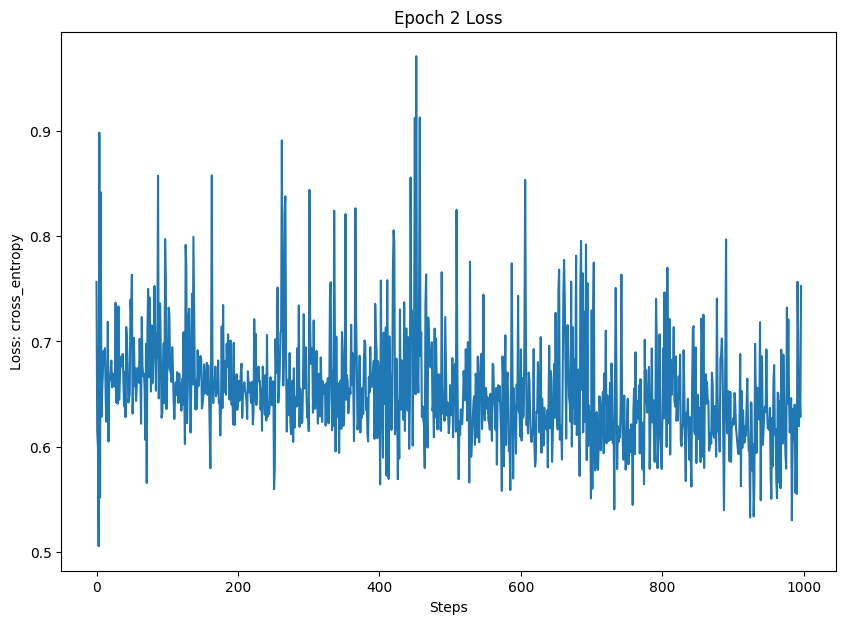


Starting epoch 3

Epoch: [3/4]		Step: [101/997]		Validation Acc: 79.25777331995988
Epoch: [3/4]		Step: [201/997]		Validation Acc: 79.45837512537612
Epoch: [3/4]		Step: [301/997]		Validation Acc: 79.73921765295887
Epoch: [3/4]		Step: [401/997]		Validation Acc: 79.89969909729187
Epoch: [3/4]		Step: [501/997]		Validation Acc: 79.9197592778335
Epoch: [3/4]		Step: [601/997]		Validation Acc: 80.18054162487462
Epoch: [3/4]		Step: [701/997]		Validation Acc: 80.320962888666
Epoch: [3/4]		Step: [801/997]		Validation Acc: 80.54162487462388
Epoch: [3/4]		Step: [901/997]		Validation Acc: 80.66198595787363


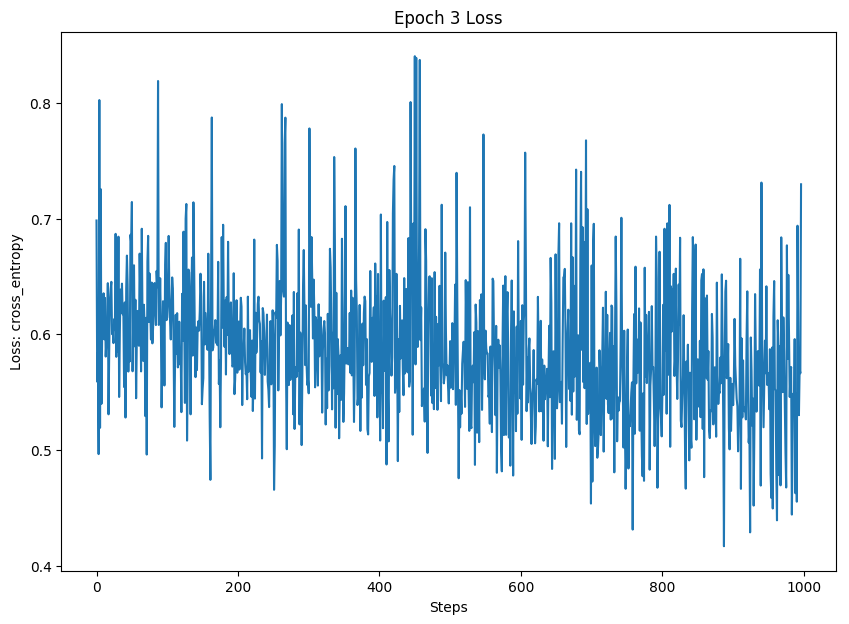


Starting epoch 4

Epoch: [4/4]		Step: [101/997]		Validation Acc: 80.90270812437312
Epoch: [4/4]		Step: [201/997]		Validation Acc: 81.00300902708125
Epoch: [4/4]		Step: [301/997]		Validation Acc: 81.08324974924774
Epoch: [4/4]		Step: [401/997]		Validation Acc: 81.22367101303912
Epoch: [4/4]		Step: [501/997]		Validation Acc: 81.22367101303912
Epoch: [4/4]		Step: [601/997]		Validation Acc: 81.44433299899698
Epoch: [4/4]		Step: [701/997]		Validation Acc: 81.38415245737211
Epoch: [4/4]		Step: [801/997]		Validation Acc: 81.78535606820462
Epoch: [4/4]		Step: [901/997]		Validation Acc: 81.62487462387162


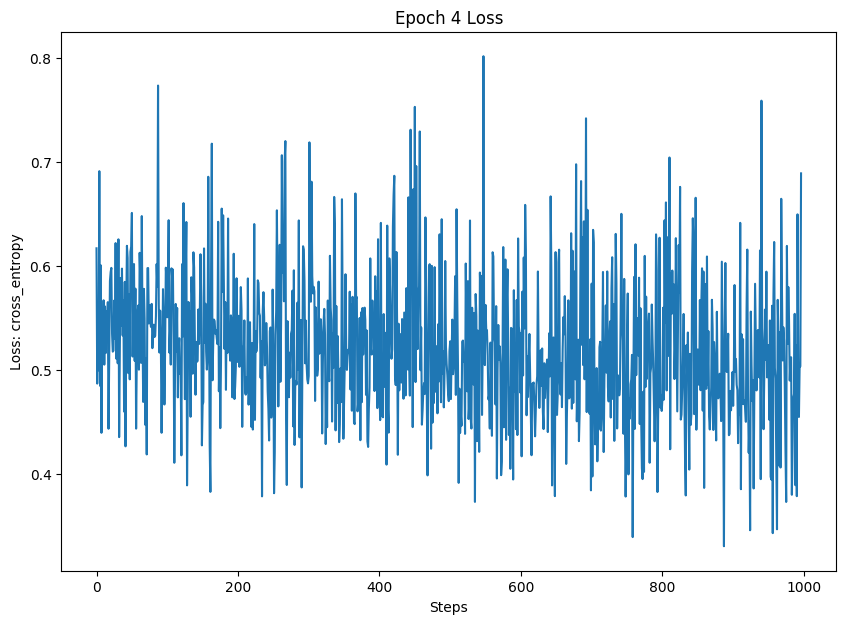

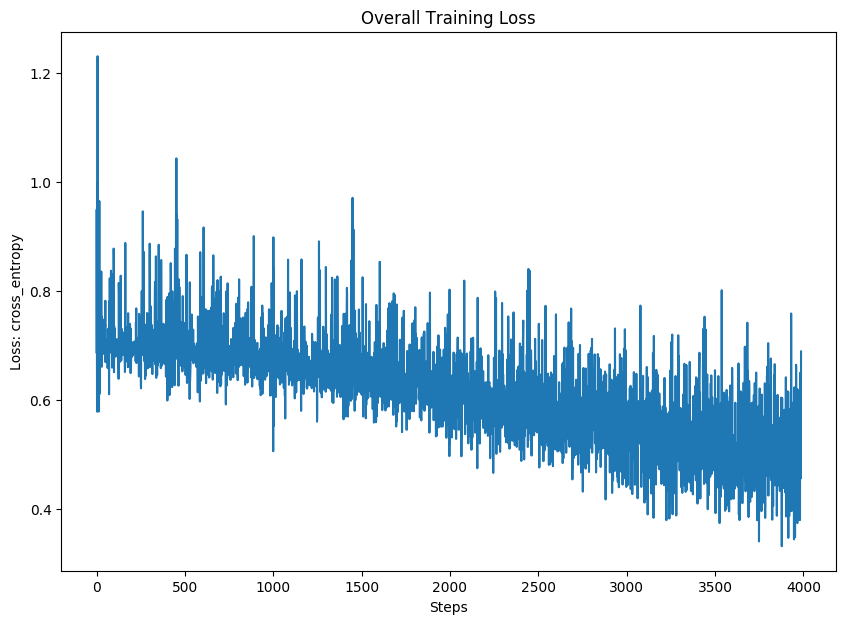

Experiment #2 Params
Percentage of vocabulary: 15000
n-grams: 4
Tokenization Scheme: 1
Learning Rate: 0.002
Epochs: 4
Batch Size: 20
Embedding Dimensions: 1000
Optimizer: adam
Loss Function: cross_entropy



Tokenizing...
Tokenizing took 1.4243311882019043 seconds.
Creating 4-grams...
Buidling vocab...

Starting epoch 1



In [ ]:
params3 = [
    [data, 10000, 4, 1, .0003, 4, 20, 1000, "adam", "cross_entropy"],
    [data, 15000, 4, 1, .002, 4, 20, 1000, "adam", "cross_entropy"],
    [data, 15000, 1, 1, .002, 4, 20, 1000, "adam", "cross_entropy"],
]
run_params(params3)

Experiment #1 Params
Percentage of vocabulary: 10000
n-grams: 1
Tokenization Scheme: 2
Learning Rate: 0.01
Epochs: 4
Batch Size: 50
Embedding Dimensions: 400
Optimizer: adam
Loss Function: cross_entropy



Tokenizing...
Tokenizing took 0.9498298168182373 seconds.
Creating 1-grams...
Buidling vocab...

Starting epoch 1

Epoch: [1/4]		Step: [101/400]		Validation Acc: 78.95579115823165
Epoch: [1/4]		Step: [201/400]		Validation Acc: 81.91638327665532
Epoch: [1/4]		Step: [301/400]		Validation Acc: 84.0368073614723


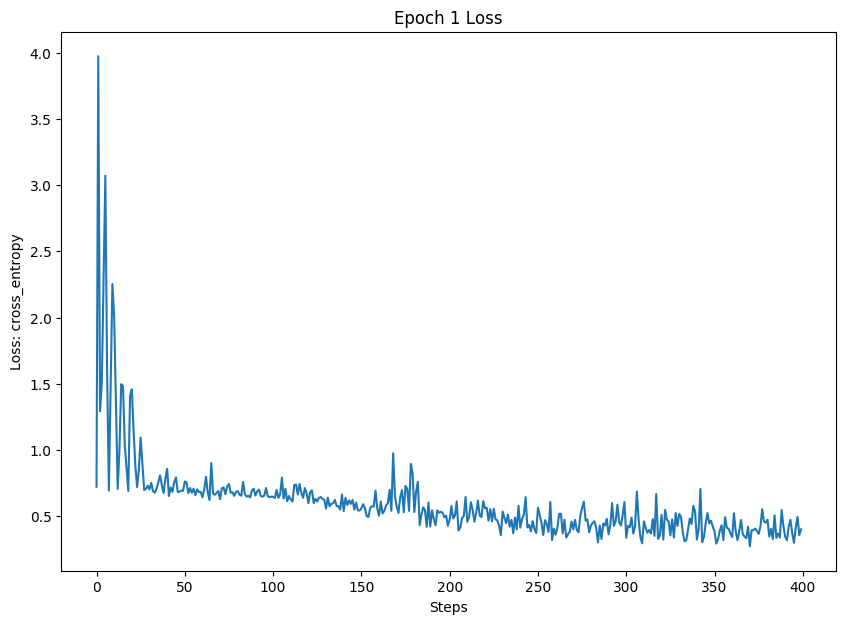


Starting epoch 2

Epoch: [2/4]		Step: [101/400]		Validation Acc: 85.41708341668334
Epoch: [2/4]		Step: [201/400]		Validation Acc: 85.49709941988398
Epoch: [2/4]		Step: [301/400]		Validation Acc: 85.07701540308062


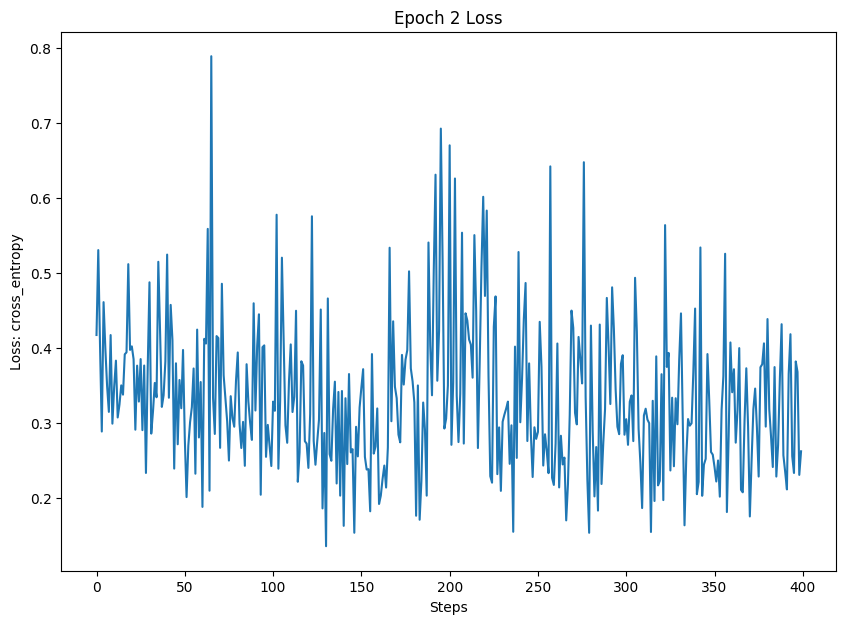


Starting epoch 3

Epoch: [3/4]		Step: [101/400]		Validation Acc: 85.61712342468493
Epoch: [3/4]		Step: [201/400]		Validation Acc: 85.67713542708542
Epoch: [3/4]		Step: [301/400]		Validation Acc: 85.29705941188237


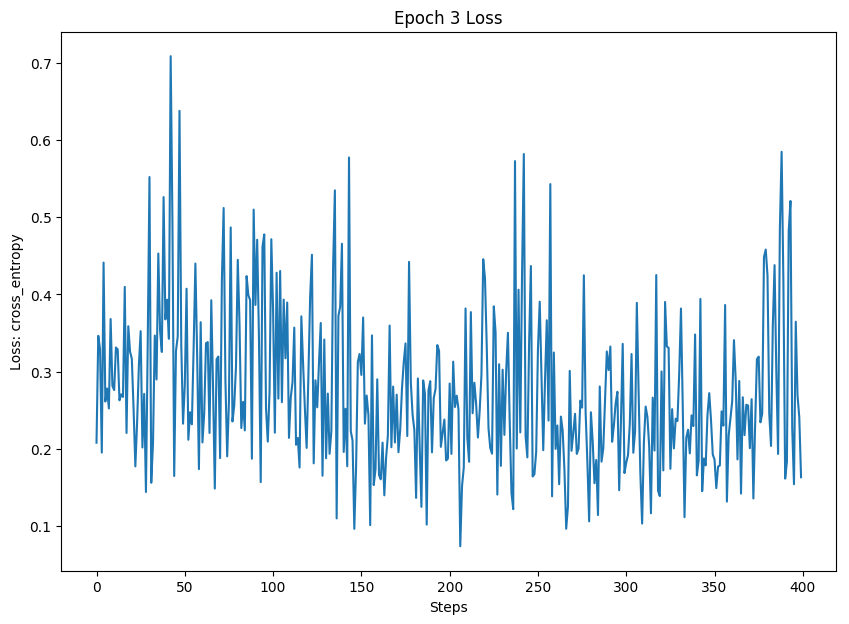


Starting epoch 4

Epoch: [4/4]		Step: [101/400]		Validation Acc: 85.15703140628126
Epoch: [4/4]		Step: [201/400]		Validation Acc: 85.25705141028206
Epoch: [4/4]		Step: [301/400]		Validation Acc: 85.0370074014803


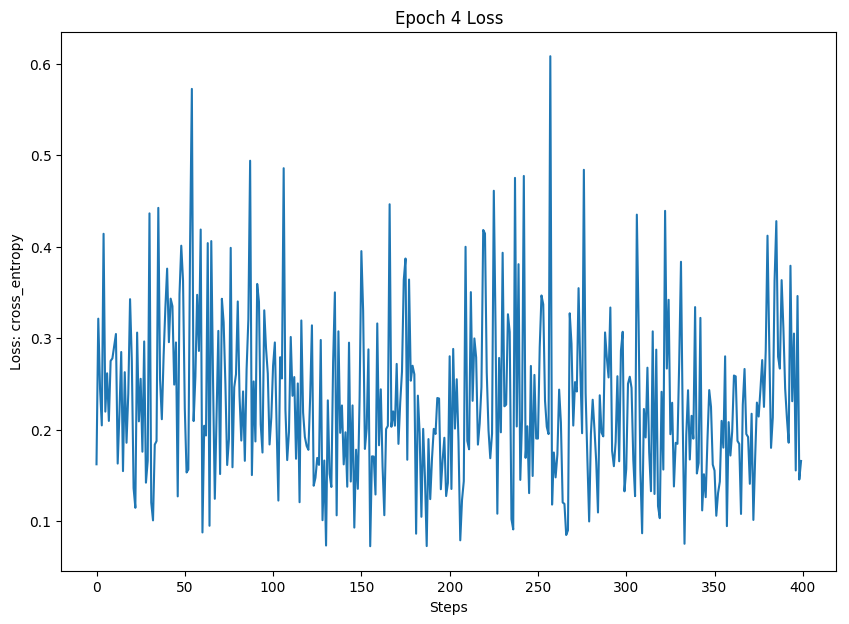

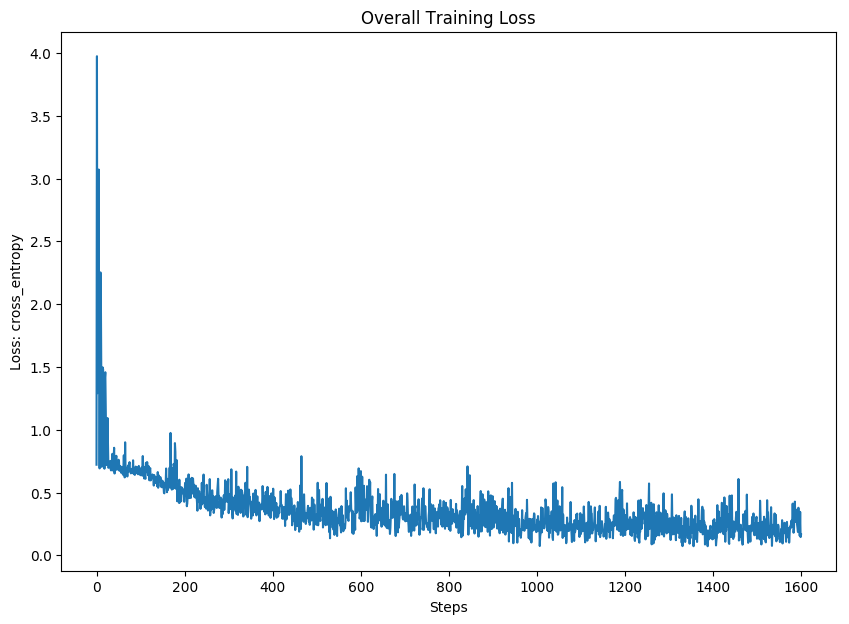

Experiment #2 Params
Percentage of vocabulary: 10000
n-grams: 1
Tokenization Scheme: 3
Learning Rate: 0.01
Epochs: 4
Batch Size: 50
Embedding Dimensions: 400
Optimizer: adam
Loss Function: cross_entropy



Tokenizing...


TypeError: expected string or bytes-like object

In [14]:
params4 = [
    [data, 10000, 1, 2, .01, 4, 50, 400, "adam", "cross_entropy"],
    [data, 10000, 1, 3, .01, 4, 50, 400, "adam", "cross_entropy"],
]
run_params(params4)

|Vocabulary Size| n-grams | tokenization scheme | Learning Rate | Epochs | Batch Size | Embedding Dimensions | Optimizer | Accuracy|
|---------------|---------|---------------------|---------------|--------|------------|----------------------|-----------|---------|
|20000          | 1       | 1                   | .001          | 5 | 10 | 5000 | sgd | 50.53|
|5000 | 3 | 1 | .001 | 4 | 32 | 200 | adam| 82.8|
|8000|4|1|.01|4|50|300|adam|83.9|
|10000|2|1|.01|4|50|2000|adam|84.2|
|15000|1|1|.2|4|50|300|adam|83.1|
|10000|1|1|2|5|40|300|sgd|49.47|
|10000|1|1|1|5|50|300|sgd|56.66|
|10000|1|1|.01|4|50|400|adam|85.1|
|10000|4|1|.0003|4|20|1000|adam|81.6|
|10000|1|2|.01|4|50|400|adam|85.5|
|10000|1|3|.01|4|50|400|adam|85.1|
|10000|1|1|.01|4|20|10|adam|83.7|
|10000|1|1|.01|4|20|30|adam|83.6|

Experiment #1 Params
Percentage of vocabulary: 10000
n-grams: 1
Tokenization Scheme: 3
Learning Rate: 0.01
Epochs: 4
Batch Size: 50
Embedding Dimensions: 400
Optimizer: adam
Loss Function: cross_entropy



Tokenizing...
Tokenizing took 0.964775800704956 seconds.
Creating 1-grams...
Buidling vocab...

Starting epoch 1

Epoch: [1/4]		Step: [101/400]		Validation Acc: 77.59103641456582
Epoch: [1/4]		Step: [201/400]		Validation Acc: 82.51300520208083
Epoch: [1/4]		Step: [301/400]		Validation Acc: 84.21368547418967


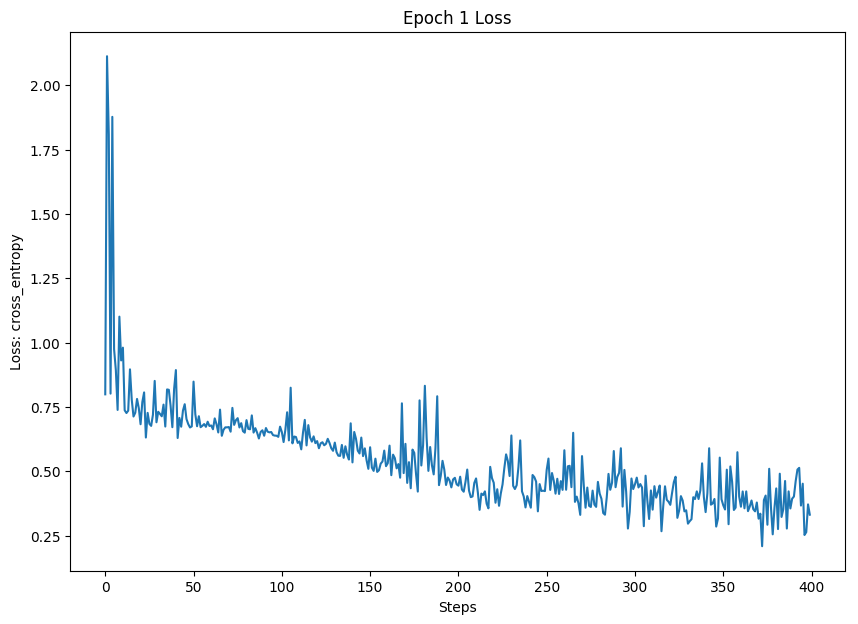


Starting epoch 2

Epoch: [2/4]		Step: [101/400]		Validation Acc: 85.15406162464986
Epoch: [2/4]		Step: [201/400]		Validation Acc: 85.17406962785114
Epoch: [2/4]		Step: [301/400]		Validation Acc: 85.07402961184474


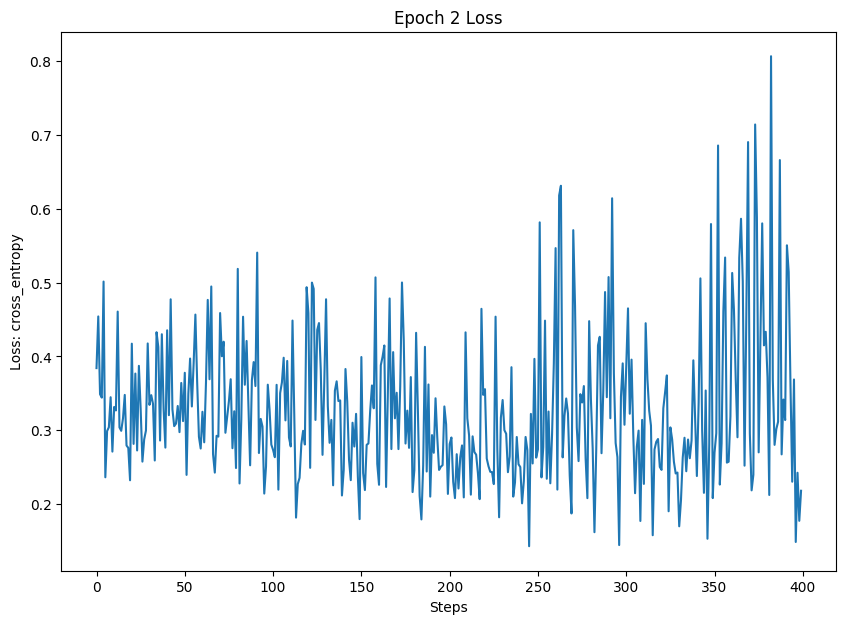


Starting epoch 3

Epoch: [3/4]		Step: [101/400]		Validation Acc: 84.77390956382553
Epoch: [3/4]		Step: [201/400]		Validation Acc: 84.6938775510204
Epoch: [3/4]		Step: [301/400]		Validation Acc: 84.6938775510204


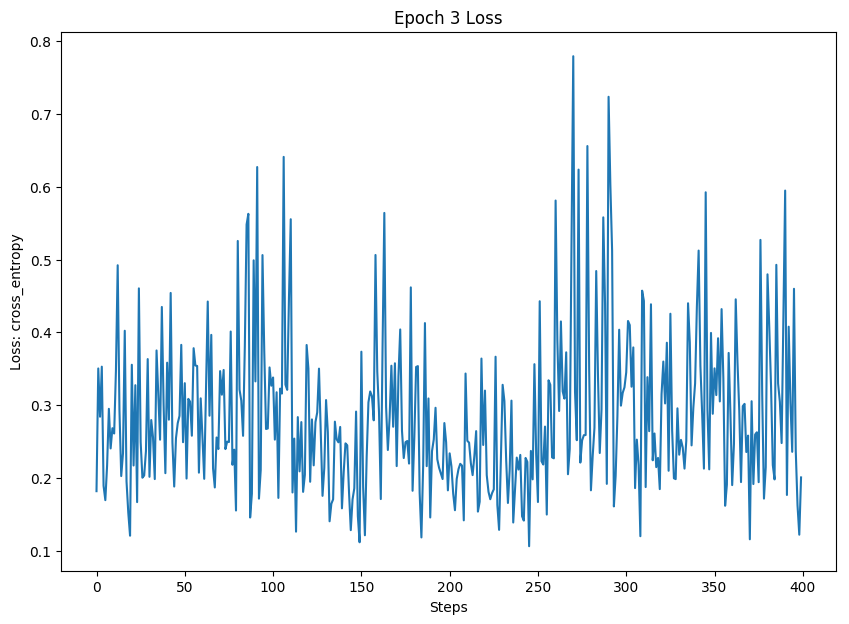


Starting epoch 4

Epoch: [4/4]		Step: [101/400]		Validation Acc: 84.27370948379351
Epoch: [4/4]		Step: [201/400]		Validation Acc: 84.03361344537815
Epoch: [4/4]		Step: [301/400]		Validation Acc: 84.19367747098839


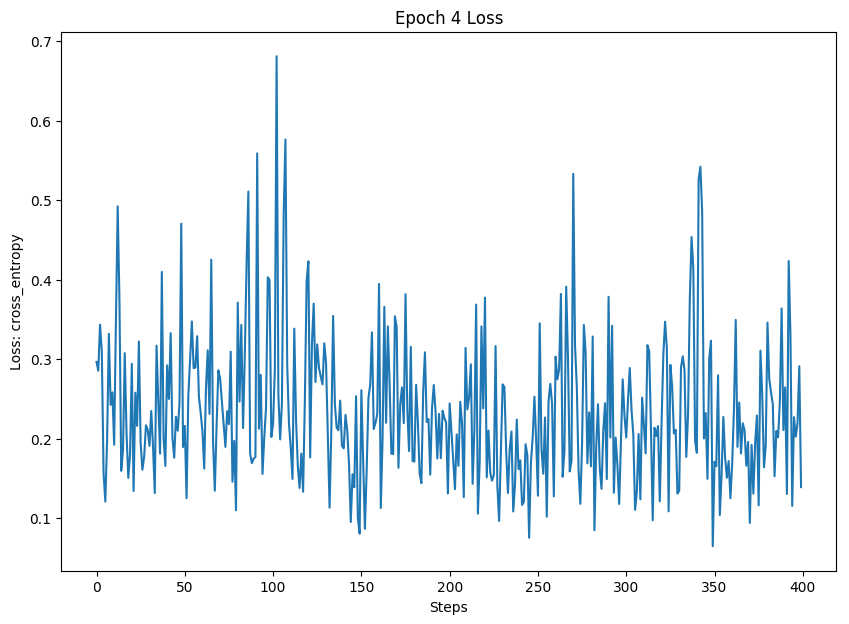

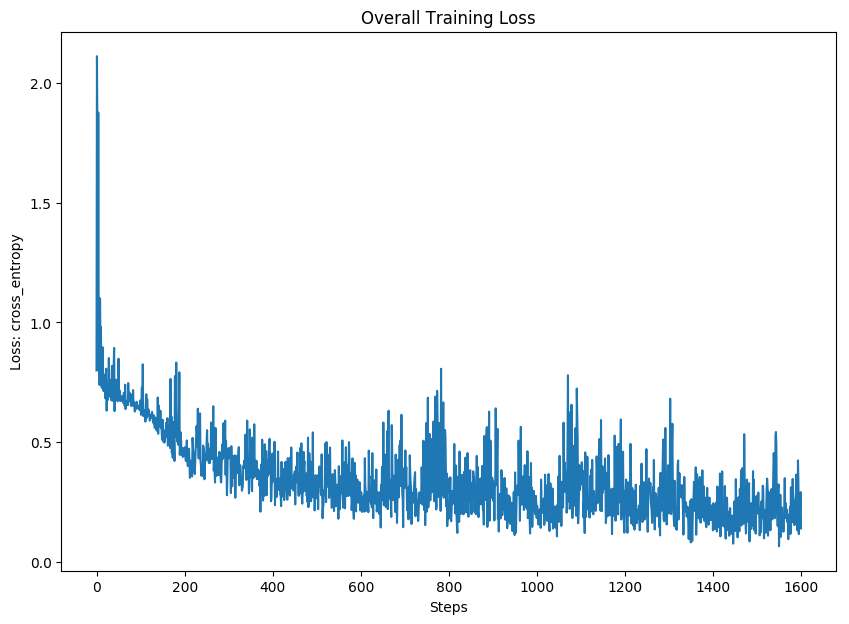

In [22]:
params5 = [
    [data, 10000, 1, 3, .01, 4, 50, 400, "adam", "cross_entropy"],
]
run_params(params5)

Experiment #1 Params
Percentage of vocabulary: 10000
n-grams: 1
Tokenization Scheme: 1
Learning Rate: 0.01
Epochs: 4
Batch Size: 20
Embedding Dimensions: 10
Optimizer: adam
Loss Function: cross_entropy



Tokenizing...
Tokenizing took 1.290226936340332 seconds.
Creating 1-grams...
Buidling vocab...

Starting epoch 1

Epoch: [1/4]		Step: [101/1000]		Validation Acc: 62.665066026410564
Epoch: [1/4]		Step: [201/1000]		Validation Acc: 71.18847539015606
Epoch: [1/4]		Step: [301/1000]		Validation Acc: 76.31052420968388
Epoch: [1/4]		Step: [401/1000]		Validation Acc: 79.63185274109644
Epoch: [1/4]		Step: [501/1000]		Validation Acc: 81.5126050420168
Epoch: [1/4]		Step: [601/1000]		Validation Acc: 81.71268507402961
Epoch: [1/4]		Step: [701/1000]		Validation Acc: 82.953181272509
Epoch: [1/4]		Step: [801/1000]		Validation Acc: 83.5734293717487
Epoch: [1/4]		Step: [901/1000]		Validation Acc: 83.81352541016406


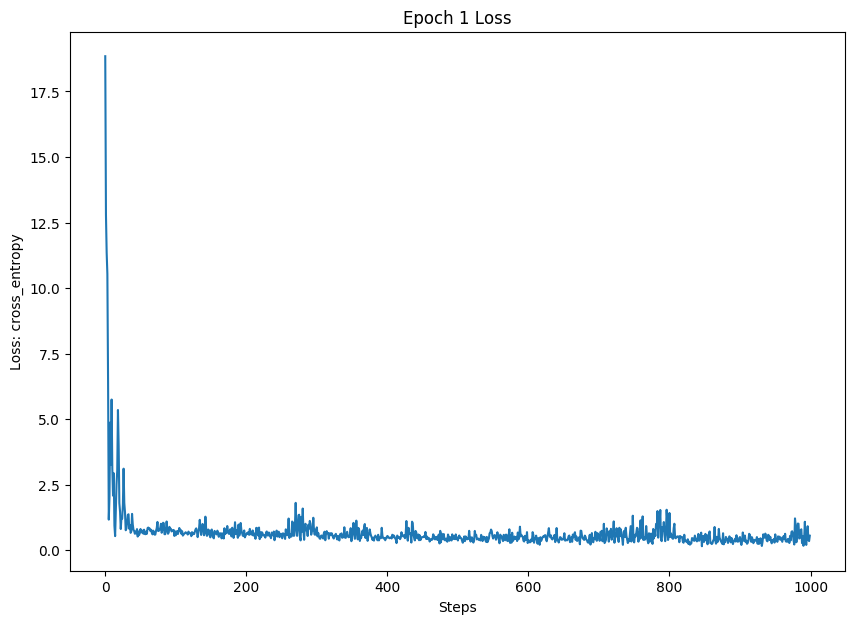


Starting epoch 2

Epoch: [2/4]		Step: [101/1000]		Validation Acc: 83.75350140056022
Epoch: [2/4]		Step: [201/1000]		Validation Acc: 84.03361344537815
Epoch: [2/4]		Step: [301/1000]		Validation Acc: 83.43337334933973
Epoch: [2/4]		Step: [401/1000]		Validation Acc: 83.89355742296918
Epoch: [2/4]		Step: [501/1000]		Validation Acc: 83.99359743897558
Epoch: [2/4]		Step: [601/1000]		Validation Acc: 83.89355742296918
Epoch: [2/4]		Step: [701/1000]		Validation Acc: 84.15366146458584
Epoch: [2/4]		Step: [801/1000]		Validation Acc: 84.21368547418967
Epoch: [2/4]		Step: [901/1000]		Validation Acc: 84.31372549019608


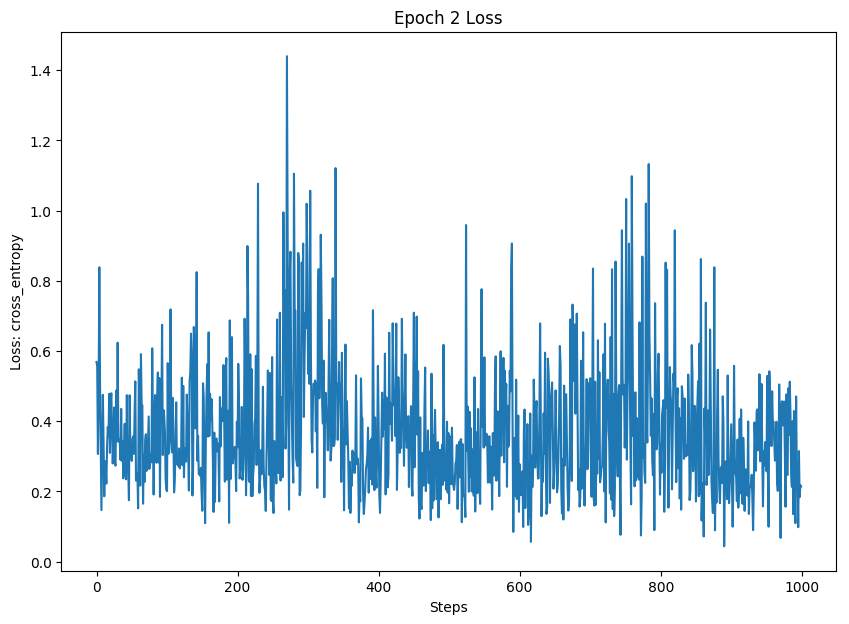


Starting epoch 3

Epoch: [3/4]		Step: [101/1000]		Validation Acc: 84.19367747098839
Epoch: [3/4]		Step: [201/1000]		Validation Acc: 83.91356542617046
Epoch: [3/4]		Step: [301/1000]		Validation Acc: 83.89355742296918
Epoch: [3/4]		Step: [401/1000]		Validation Acc: 84.45378151260505
Epoch: [3/4]		Step: [501/1000]		Validation Acc: 84.45378151260505
Epoch: [3/4]		Step: [601/1000]		Validation Acc: 84.05362144857943
Epoch: [3/4]		Step: [701/1000]		Validation Acc: 84.33373349339736
Epoch: [3/4]		Step: [801/1000]		Validation Acc: 84.03361344537815
Epoch: [3/4]		Step: [901/1000]		Validation Acc: 84.09363745498199


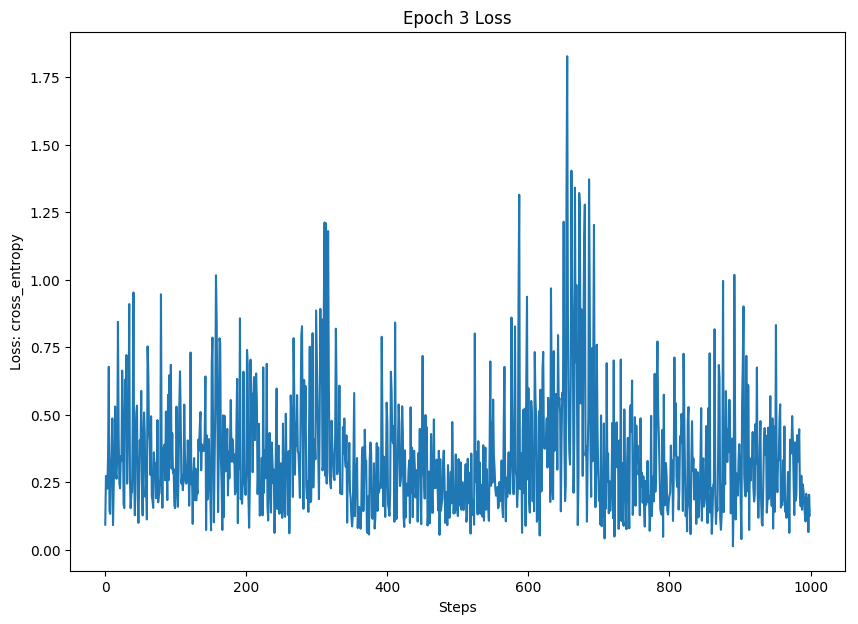


Starting epoch 4

Epoch: [4/4]		Step: [101/1000]		Validation Acc: 83.91356542617046
Epoch: [4/4]		Step: [201/1000]		Validation Acc: 83.83353341336534
Epoch: [4/4]		Step: [301/1000]		Validation Acc: 83.63345338135254
Epoch: [4/4]		Step: [401/1000]		Validation Acc: 83.87354941976791
Epoch: [4/4]		Step: [501/1000]		Validation Acc: 83.69347739095639
Epoch: [4/4]		Step: [601/1000]		Validation Acc: 83.83353341336534
Epoch: [4/4]		Step: [701/1000]		Validation Acc: 83.91356542617046
Epoch: [4/4]		Step: [801/1000]		Validation Acc: 83.49339735894358
Epoch: [4/4]		Step: [901/1000]		Validation Acc: 83.71348539415766


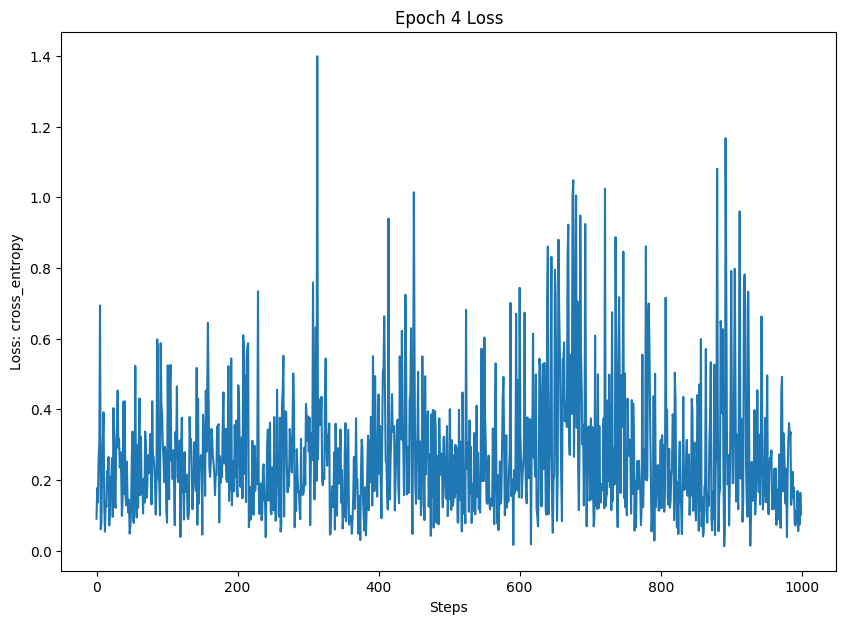

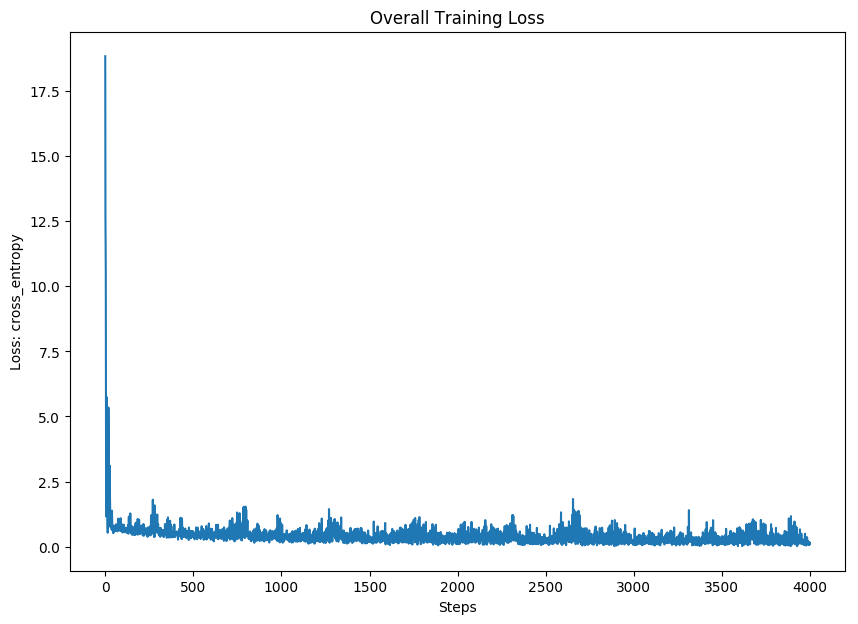

Experiment #2 Params
Percentage of vocabulary: 10000
n-grams: 1
Tokenization Scheme: 1
Learning Rate: 0.01
Epochs: 4
Batch Size: 20
Embedding Dimensions: 30
Optimizer: adam
Loss Function: cross_entropy



Tokenizing...
Tokenizing took 1.2148241996765137 seconds.
Creating 1-grams...
Buidling vocab...

Starting epoch 1

Epoch: [1/4]		Step: [101/1000]		Validation Acc: 64.70588235294117
Epoch: [1/4]		Step: [201/1000]		Validation Acc: 72.94917967186875
Epoch: [1/4]		Step: [301/1000]		Validation Acc: 79.11164465786314
Epoch: [1/4]		Step: [401/1000]		Validation Acc: 80.87234893957583
Epoch: [1/4]		Step: [501/1000]		Validation Acc: 81.17246898759504
Epoch: [1/4]		Step: [601/1000]		Validation Acc: 82.57302921168467
Epoch: [1/4]		Step: [701/1000]		Validation Acc: 82.93317326930773
Epoch: [1/4]		Step: [801/1000]		Validation Acc: 83.31332533013206
Epoch: [1/4]		Step: [901/1000]		Validation Acc: 83.73349339735894


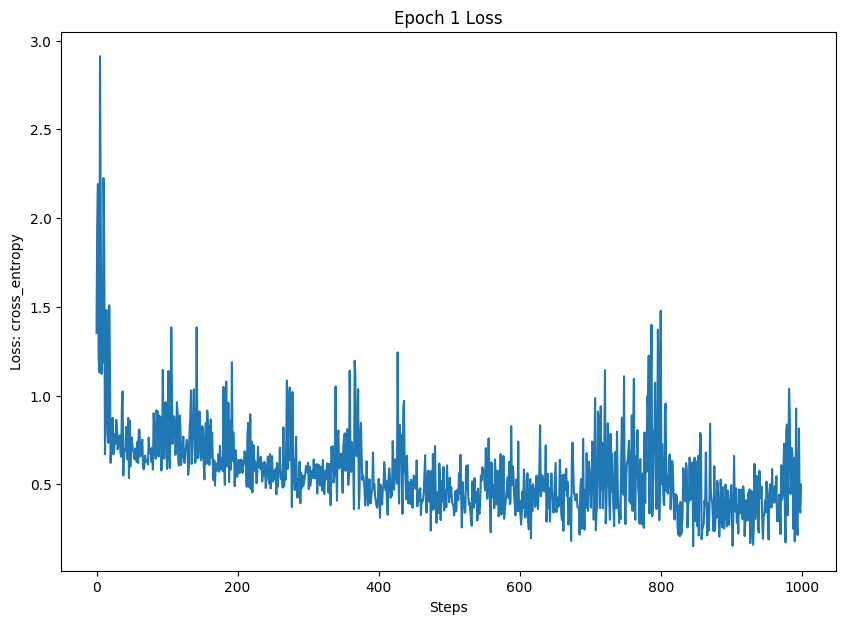


Starting epoch 2

Epoch: [2/4]		Step: [101/1000]		Validation Acc: 84.17366946778712
Epoch: [2/4]		Step: [201/1000]		Validation Acc: 84.15366146458584
Epoch: [2/4]		Step: [301/1000]		Validation Acc: 84.09363745498199
Epoch: [2/4]		Step: [401/1000]		Validation Acc: 84.19367747098839
Epoch: [2/4]		Step: [501/1000]		Validation Acc: 84.21368547418967
Epoch: [2/4]		Step: [601/1000]		Validation Acc: 84.25370148059224
Epoch: [2/4]		Step: [701/1000]		Validation Acc: 84.2937174869948
Epoch: [2/4]		Step: [801/1000]		Validation Acc: 84.17366946778712
Epoch: [2/4]		Step: [901/1000]		Validation Acc: 84.63385354141657


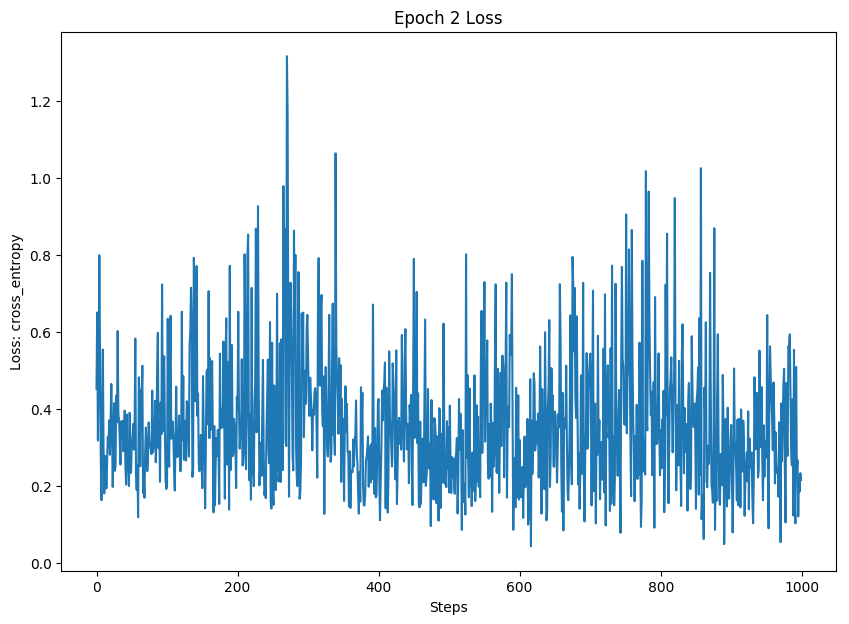


Starting epoch 3

Epoch: [3/4]		Step: [101/1000]		Validation Acc: 84.11364545818327
Epoch: [3/4]		Step: [201/1000]		Validation Acc: 84.27370948379351
Epoch: [3/4]		Step: [301/1000]		Validation Acc: 84.25370148059224
Epoch: [3/4]		Step: [401/1000]		Validation Acc: 84.05362144857943
Epoch: [3/4]		Step: [501/1000]		Validation Acc: 84.01360544217687
Epoch: [3/4]		Step: [601/1000]		Validation Acc: 84.15366146458584
Epoch: [3/4]		Step: [701/1000]		Validation Acc: 84.37374949979991
Epoch: [3/4]		Step: [801/1000]		Validation Acc: 83.87354941976791
Epoch: [3/4]		Step: [901/1000]		Validation Acc: 84.21368547418967


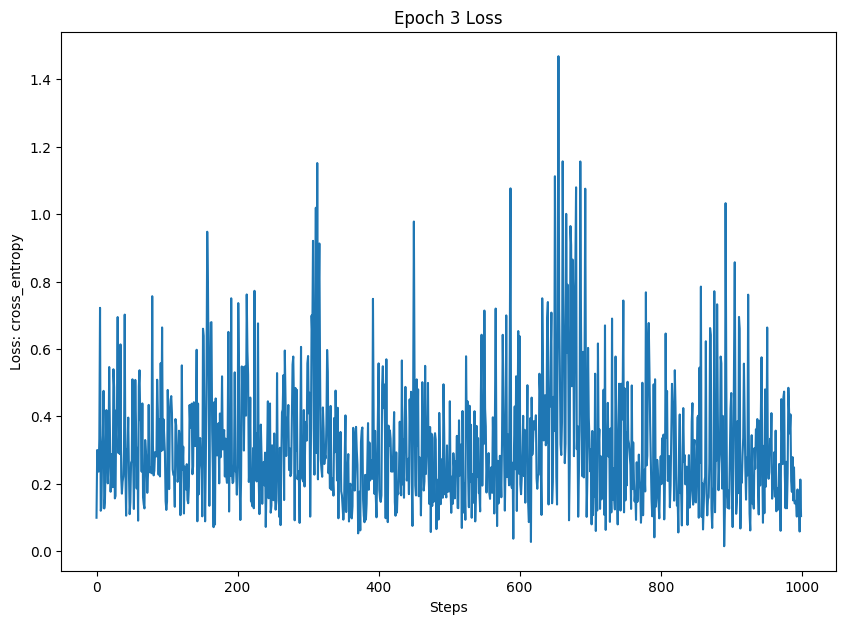


Starting epoch 4

Epoch: [4/4]		Step: [101/1000]		Validation Acc: 83.93357342937175
Epoch: [4/4]		Step: [201/1000]		Validation Acc: 83.77350940376151
Epoch: [4/4]		Step: [301/1000]		Validation Acc: 83.63345338135254
Epoch: [4/4]		Step: [401/1000]		Validation Acc: 83.81352541016406
Epoch: [4/4]		Step: [501/1000]		Validation Acc: 83.55342136854742
Epoch: [4/4]		Step: [601/1000]		Validation Acc: 83.93357342937175
Epoch: [4/4]		Step: [701/1000]		Validation Acc: 83.81352541016406
Epoch: [4/4]		Step: [801/1000]		Validation Acc: 83.39335734293718
Epoch: [4/4]		Step: [901/1000]		Validation Acc: 83.85354141656663


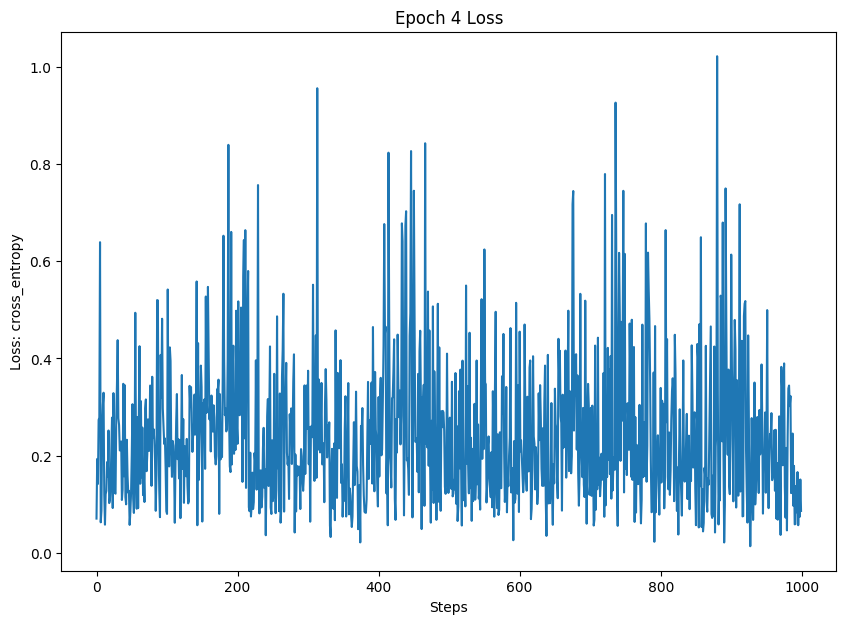

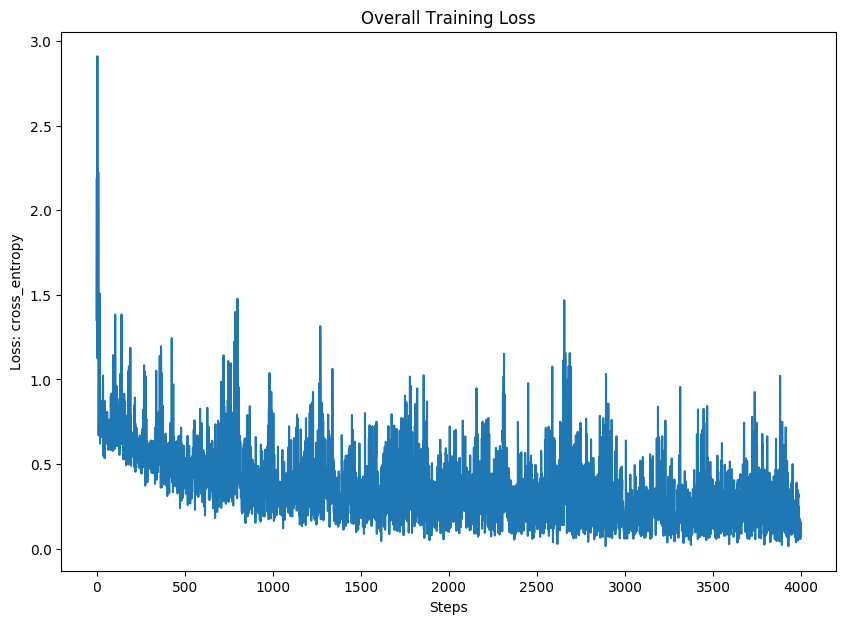

In [24]:
params6 = [
    [data, 10000, 1, 1, .01, 4, 20, 10, "adam", "cross_entropy"],
    [data, 10000, 1, 1, .01, 4, 20, 30, "adam", "cross_entropy"],
]
run_params(params6)

In [91]:
model, trainer = run(data, 10000, 1, 1, .01, 4, 50, 400, "adam", "cross_entropy")

Tokenizing...
Tokenizing took 1.0332322120666504 seconds.
Creating 1-grams...
Buidling vocab...

Starting epoch 1



RuntimeError: index out of range at /Users/soumith/code/builder/wheel/pytorch-src/aten/src/TH/generic/THTensorMath.cpp:352

In [ ]:
test_X, test_y = data.prepare_testing(1)

In [ ]:
results = trainer.test(model, test_X, test_y)

In [ ]:
accuracy, result = results

In [ ]:
accuracy

In [ ]:
accum = []
for r in result:
    review = " ".join([data.vocab[i] for i in r[0].tolist()[0]])
    was_correct = r[1] == r[2]
    accum.append((review, r[1].tolist()[0], was_correct))

In [ ]:
for i in np.random.choice(len(accum), 100, replace=False):
    review, sentiment, was_correct = accum[i]
    sentiment_message = "\33[32mpositive\33[0m" if sentiment == 1 else "\33[91mnegative\33[0m"
    was_correct_message = "\33[32m[✓]\33[0m" if was_correct else "\33[91m[ˣ]\33[0m"
    print("Review:\n{}\nSentiment: {}\nCorrect Prediction? {}\n\n".format(review, sentiment_message, was_correct_message))